# 2.Linebot設計
當 query 包含"身高"、"體重"、"年齡"、"收入"等隱私時，回覆以下貼圖

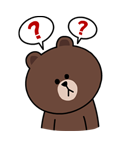

In [1]:
from IPython.display import Image
Image(filename='play_dumb.png')

In [2]:
import configparser
from flask import Flask, request, abort
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import *

app = Flask(__name__)

# LINE 聊天機器人的基本資料
config = configparser.ConfigParser()
config.read('config.ini')

line_bot_api = LineBotApi(config.get('line-bot', 'channel_access_token'))
handler = WebhookHandler(config.get('line-bot', 'channel_secret'))

# 接收 LINE 資訊
@app.route('/callback', methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info('Request body: ' + body)

    try:
        print('body:', body)
        print('signature:', signature)
        print('=' * 5)
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)

    return 'OK'

# 回覆設定(default 僅能回固定語句)
@handler.add(MessageEvent, message=TextMessage)
def get_response(event):
    query = event.message.text

    sens = ['身高', '體重', '年齡', '收入']
    if any(s in query for s in sens):
        line_bot_api.reply_message(event.reply_token,StickerSendMessage(package_id=2, sticker_id=149))
    else:
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="嗨嗨"))


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


body: {"events":[{"type":"message","replyToken":"78e8c69d90c74f138d250b76ea551a19","source":{"userId":"Uf4a7c12620964b85afe462da583cc510","type":"user"},"timestamp":1616336506999,"mode":"active","message":{"type":"text","id":"13757130304382","text":"你今年幾歲？"}}],"destination":"Uc5a660caf7116f3beb24a9621ce1eb12"}
signature: gcxyWuiu8eDXowozBTvKPXmIFy98tFA12G+yCk558no=
=====


127.0.0.1 - - [21/Mar/2021 22:21:48] "POST /callback HTTP/1.1" 200 -


body: {"events":[{"type":"message","replyToken":"7152bee329094633b9ed3759d24fc3e7","source":{"userId":"Uf4a7c12620964b85afe462da583cc510","type":"user"},"timestamp":1616336527018,"mode":"active","message":{"type":"text","id":"13757131866956","text":"收入多少？"}}],"destination":"Uc5a660caf7116f3beb24a9621ce1eb12"}
signature: YMnuXS15sWW26Et7QnrtDHsyV1vXQZ1BmfwHuXpaKgM=
=====


127.0.0.1 - - [21/Mar/2021 22:22:08] "POST /callback HTTP/1.1" 200 -


## 3.以Python實現多輪對話
於多輪對話情境中加入"取得股價資訊的功能"，query 為公司簡稱時(ex:鴻海)，即輸出 2020/12/1 ~ 12/10 之股價資訊

In [3]:
import configparser
from flask import Flask, request, abort
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import *

import stock_utils as Stock
import thsr_utils as Thsr
thsr = Thsr.ThsrModule()

chat_record = []
thsr_res = {'starting': '', 'ending': '', 'date': '', 'ampm': ''}
station_names = Thsr.station_name
date_keys = Thsr.date_key
ampm_keys = Thsr.ampm_key


app = Flask(__name__)

# LINE 聊天機器人的基本資料
config = configparser.ConfigParser()
config.read('config.ini')

line_bot_api = LineBotApi(config.get('line-bot', 'channel_access_token'))
handler = WebhookHandler(config.get('line-bot', 'channel_secret'))

# 接收 LINE 資訊
@app.route('/callback', methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info('Request body: ' + body)

    try:
        print('body:', body)
        print('signature:', signature)
        print('=' * 5)
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)

    return 'OK'

# 回覆設定 (高鐵 API 多輪對話以及"加入取得股價資訊的功能")
@handler.add(MessageEvent, message=TextMessage)
def get_response(event):
    query = event.message.text
    
    if len(chat_record) < 5:
        chat_record.append(query)
    else:
        chat_record.pop(0)
        chat_record.append(query)
    print('chat_record:', chat_record)

    # 判斷是否為"高鐵查詢意圖"
    if query == '高鐵':
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text='哪一天出發?'))
    try:
        if chat_record[-2] == '高鐵' and any(chat_record[-1] == i for i in date_keys):
            date_format = thsr.get_date_string_today(chat_record[-1])
            thsr_res['date'] = date_format
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text='上午還是下午的車?'))
        elif any(chat_record[-2] == i for i in date_keys) and any(chat_record[-1] == i for i in ampm_keys):
            thsr_res['ampm'] = chat_record[-1]
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text='起站是哪裡呢?'))
        elif any(chat_record[-2] == i for i in ampm_keys) and any(chat_record[-1] == i for i in station_names):
            startind_id = Thsr.station_id[chat_record[-1]]
            thsr_res['starting'] = startind_id
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text='終點站是哪裡呢?'))
        elif any(chat_record[-2] == i for i in station_names) and any(chat_record[-1] == i for i in station_names):
            ending_id = Thsr.station_id[chat_record[-1]]
            thsr_res['ending'] = ending_id
            text = thsr.get_runs(thsr_res['starting'], thsr_res['ending'], thsr_res['date'], thsr_res['ampm'])
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text=text))
    except IndexError:
        pass

    # 判斷是否為"股價詢問意圖"
    if query == '股票':
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="找哪一支股票?"))
    try:
        if "股票" in chat_record:
            ss = Stock.stock_symbol
            if any(sk == query for sk in list(ss.keys())):
                stock_symbol = ss[query]
                stock_data = Stock.get_stockdata(stock_symbol, '2020-12-01', '2020-12-10')
                stock_info = Stock.get_stockinfo(query, stock_data, 'Close')
                line_bot_api.reply_message(event.reply_token, TextSendMessage(text=stock_info))
    except:
        pass

    line_bot_api.reply_message(event.reply_token, TextSendMessage(text="不論你說什麼 我都回你好!"))


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


body: {"events":[{"type":"message","replyToken":"8cb80d359f44472384c076fe1bcda00f","source":{"userId":"Uf4a7c12620964b85afe462da583cc510","type":"user"},"timestamp":1616336545219,"mode":"active","message":{"type":"text","id":"13757133317119","text":"股票"}}],"destination":"Uc5a660caf7116f3beb24a9621ce1eb12"}
signature: bghINZig5pMoS/P3CUH3IPYNQ2zwMZ+eS8PssT+Om7c=
=====
chat_record: ['股票']


[2021-03-21 22:22:26,796] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-3-d2e9ff3c8696>", line 38, in callback
    handler.handle(body, signature)
  File 

body: {"events":[{"type":"message","replyToken":"bfe510ae71714b5cbfa7e5e3f303491d","source":{"userId":"Uf4a7c12620964b85afe462da583cc510","type":"user"},"timestamp":1616336551180,"mode":"active","message":{"type":"text","id":"13757133800971","text":"台積電"}}],"destination":"Uc5a660caf7116f3beb24a9621ce1eb12"}
signature: zhSSNg6IwNGTc8ZYx0pDcKirkCyV5UwsdORDgKfqQQA=
=====
chat_record: ['股票', '台積電']
[*********************100%***********************]  1 of 1 completed


[2021-03-21 22:22:33,132] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-3-d2e9ff3c8696>", line 38, in callback
    handler.handle(body, signature)
  File 